In [1]:
import json 
import os 
import ast
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from tabulate import tabulate


In [2]:
def get_results(filename):
    results = json.load(open(filename))
    analysis = {}
    for j in range(100):
        try:
            result = results[j]
            id = result['task_id']
            reward = result['reward']
            original_subtasks = len(ast.literal_eval(result['traj'][4]['content'].split('Subtasks solved: ')[1].strip()))
            subtasks_unsolved_before_last_step = ast.literal_eval(result['traj'][-2]['content'].split('Subtasks solved: ')[1].strip())
            subtasks_unsolved_after_last_step = 0
            for i in range(len(subtasks_unsolved_before_last_step)):
                if not subtasks_unsolved_before_last_step[i]:
                    subtasks_unsolved_after_last_step += 1

            analysis[id] = {'reward': reward, 'subtasks_unsolved': subtasks_unsolved_after_last_step, 'original_subtasks': original_subtasks}
        except:
            print(j)
    return analysis

In [58]:
def get_results_for_dynamic(filename):
    results = json.load(open(filename))
    analysis = {}
    # results = [results[22]]
    for j in range(100):
        result = results[j]
        id = result['task_id']
        print(len(result['traj']))
        try:
            reward = result['reward']
            index = -1
            for i in range(len(result['traj'])-1, -1, -1):
                print(i, result['traj'][i]['role'])
                if result['traj'][i]['role'] == 'subtask_creator':
                    index = i-1
                    break
            print(index)
            step = result['traj'][index]['content']
            if 'Subtasks solved: ' not in step:
                print(j, step)
                continue
            step = step.split('Subtasks solved: ')[1].strip()
            if step == '[]':
                subtasks_unsolved_after_last_step = 0
            else:
                subtasks_after_last_step = ast.literal_eval(step)
                subtasks_unsolved_after_last_step = 0
                for i in range(len(subtasks_after_last_step)):
                    if not subtasks_after_last_step[i]:
                        subtasks_unsolved_after_last_step += 1

            analysis[id] = {'reward': reward, 'subtasks_unsolved': subtasks_unsolved_after_last_step, 'original_subtasks': 5}
        except Exception as e:
            print(id, e)
    return analysis

In [52]:
def plot_algorithms_comparison(*algorithms_data, algorithm_names=None):
    """
    Plots comparison charts for multiple algorithms showing task outcome and reward logic.
    
    Args:
        *algorithms_data: Dictionaries with task info (reward, subtasks_unsolved, original_subtasks)
        algorithm_names: Optional list of names for labeling each algorithm
    """
    num_algos = len(algorithms_data)

    if algorithm_names is None:
        algorithm_names = [f"Algorithm {i+1}" for i in range(num_algos)]
    elif len(algorithm_names) != num_algos:
        raise ValueError("Length of algorithm_names must match number of algorithms_data")

    # Get union of all task IDs
    all_task_ids = sorted(set().union(*(data.keys() for data in algorithms_data)))
    x = np.arange(len(all_task_ids))

    def get_plot_data(data):
        heights, colors, dots_y, markers, marker_colors = [], [], [], [], []
        for tid in all_task_ids:
            if tid in data:
                d = data[tid]
                reward = d['reward']
                unsolved = d['subtasks_unsolved']
                total = d['original_subtasks']
                heights.append(total)

                # Determine color based on reward & unsolved consistency
                if reward == 1.0 and unsolved > 0:
                    colors.append('red')    # Mistaken reward
                elif reward == 0.0 and unsolved == 0:
                    colors.append('blue')   # Mistaken no reward
                else:
                    colors.append('gray')   # Correct behavior

                # Marker and color
                if reward == 1.0:
                    markers.append('✓')
                    marker_colors.append('green')
                else:
                    markers.append('✗')
                    marker_colors.append('red')

                dots_y.append(unsolved)
            else:
                heights.append(0)
                colors.append('white')
                dots_y.append(0)
                markers.append('')
                marker_colors.append('black')
        return heights, colors, dots_y, markers, marker_colors

    # Create subplots
    fig, axes = plt.subplots(num_algos, 1, figsize=(18, 5 * num_algos), sharex=True)
    if num_algos == 1:
        axes = [axes]

    for i, (data, ax, name) in zip(range(num_algos), zip(algorithms_data, axes, algorithm_names)):
        heights, colors, dots_y, markers, marker_colors = get_plot_data(data)

        ax.bar(x, heights, color=colors)
        ax.scatter(x, dots_y, color='black', zorder=5, s=30)

        # Markers: ✓ (green) or ✗ (red)
        for xi, hi, mark, mcolor in zip(x, heights, markers, marker_colors):
            if mark:
                ax.text(xi, hi + 0.2, mark, ha='center', va='bottom', fontsize=12, color=mcolor)

        ax.set_title(f"{name}")
        ax.set_ylabel("Original Subtasks")
        ax.grid(True, axis='y')
        ax.set_xticks(x)
        ax.set_xticklabels(all_task_ids, rotation=90, fontsize=9)

    axes[-1].set_xlabel("Task ID")

    # Add legend
    legend_elements = [
        Patch(facecolor='gray', label='✅ Correct outcome'),
        Patch(facecolor='red', label='❌ Reward=1 but Unsolved > 0'),
        Patch(facecolor='blue', label='❌ Reward=0 but Unsolved = 0'),
        Patch(facecolor='white', edgecolor='black', label='⛔ Missing Task'),
        Patch(facecolor='black', label='• Unsolved Subtasks')
    ]
    axes[0].legend(handles=legend_elements, loc='upper right')

    # plt.tight_layout()
    plt.show()


In [53]:
def summarize_algorithm_results(*algorithms_data, algorithm_names=None, task_ids=None):
    """
    Summarizes classification outcomes for multiple algorithms.
    
    Args:
        *algorithms_data: Dicts with task_id -> {reward, subtasks_unsolved, original_subtasks}
        algorithm_names: Optional names for each algorithm
        task_ids: Optional list of task IDs to unify (default: union of all)
    """
    num_algos = len(algorithms_data)

    if algorithm_names is None:
        algorithm_names = [f"Algorithm {i+1}" for i in range(num_algos)]
    elif len(algorithm_names) != num_algos:
        raise ValueError("algorithm_names length must match algorithms_data length")

    # Gather all task IDs
    if task_ids is None:
        task_ids = sorted(set().union(*(data.keys() for data in algorithms_data)))

    summary = []
    
    for name, data in zip(algorithm_names, algorithms_data):
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        missing = 0
        
        for tid in task_ids:
            if tid not in data:
                missing += 1
                continue
            entry = data[tid]
            reward = entry['reward']
            unsolved = entry['subtasks_unsolved']

            if reward == 1.0 and unsolved == 0:
                tn += 1
            if reward == 0.0 and unsolved > 0:
                tp += 1
            if reward == 1.0 and unsolved > 0:
                fp += 1
            if reward == 0.0 and unsolved == 0:
                fn += 1
            
        summary.append({
            "Algorithm": name,
            "Solved but subtasks pending": fp,
            "Solved and no pending subtask": tn,
            "Not solved but no pending subtask": fn,
            "Not solved and pending tasks": tp,
            "Total Tasks": tp+tn+fp+fn
        })

    df = pd.DataFrame(summary)
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))
    return df

56
55 subtask_creator
54
52
51 subtask_creator
50
52
51 subtask_creator
50
46
45 subtask_creator
44
56
55 subtask_creator
54
52
51 subtask_creator
50
50
49 subtask_creator
48
64
63 subtask_creator
62
56
55 subtask_creator
54
44
43 subtask_creator
42
36
35 tool
34 assistant
33 subtask_creator
32
50
49 subtask_creator
48
30
29 tool
28 assistant
27 subtask_creator
26
42
41 subtask_creator
40
50
49 subtask_creator
48
48
47 subtask_creator
46
54
53 subtask_creator
52
46
45 subtask_creator
44
62
61 tool
60 assistant
59 subtask_creator
58
52
51 subtask_creator
50
56
55 subtask_creator
54
50
49 subtask_creator
48
0
-1
22 list index out of range
82
81 subtask_creator
80
50
49 subtask_creator
48
48
47 tool
46 assistant
45 subtask_creator
44
50
49 subtask_creator
48
42
41 tool
40 assistant
39 subtask_creator
38
68
67 subtask_creator
66
78
77 subtask_creator
76
108
107 subtask_creator
106
86
85 subtask_creator
84
88
87 subtask_creator
86
72
71 subtask_creator
70
0
-1
34 list index out of range
72


c:\Users\t-avalsingh\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\t-avalsingh\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\t-avalsingh\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9940 (\N{NO ENTRY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


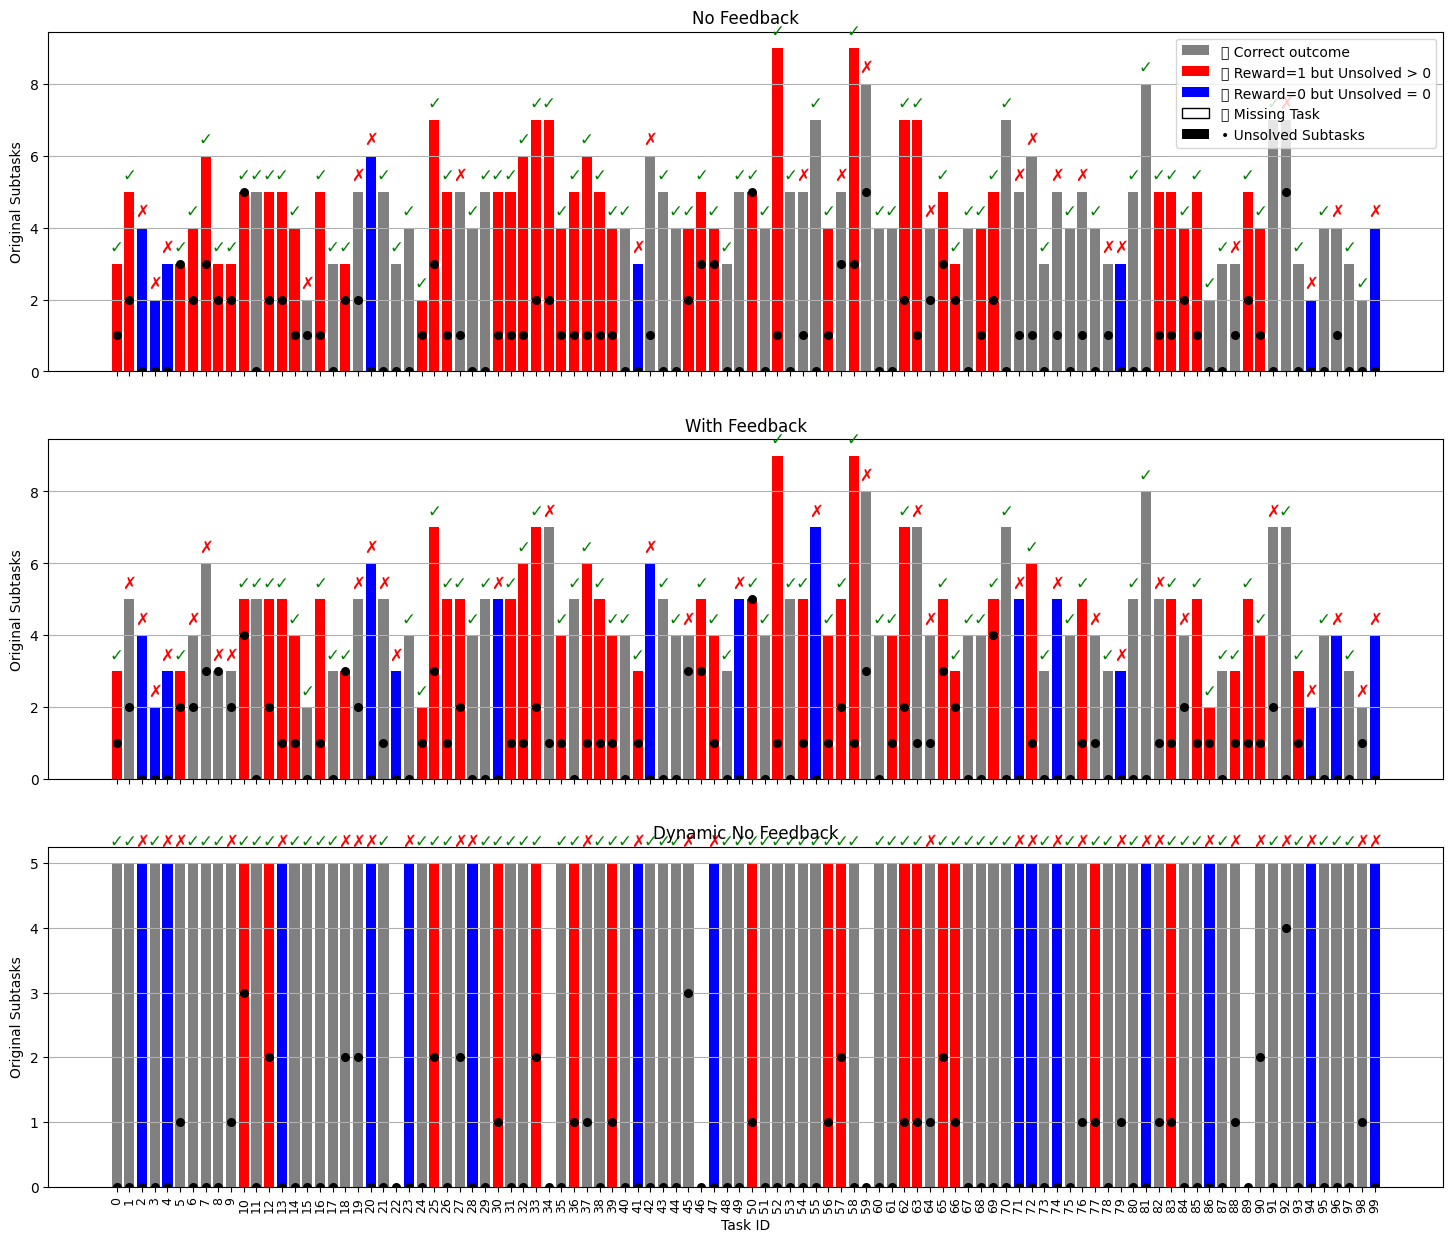

In [59]:
no_feedback = 'final_results/tool-calling-with-subtasks-check-none-0.1_range_0--1_user-none-llm_0714135412.json'
with_feedback = 'final_results/tool-calling-with-subtasks-feedback-none-0.1_range_0--1_user-none-llm_0715112655.json'
dynamic_no_feedback = 'final_results/tool-calling-with-dynamic-subtasks-none-0.1_range_0--1_user-none-llm_0716114053.json'
no_feedback_data = get_results(no_feedback)
with_feedback_data = get_results(with_feedback)
dynamic_no_feedback_data = get_results_for_dynamic(dynamic_no_feedback)
plot_algorithms_comparison(no_feedback_data, with_feedback_data, dynamic_no_feedback_data, algorithm_names=['No Feedback', 'With Feedback', 'Dynamic No Feedback'])

In [60]:
summarize_algorithm_results(no_feedback_data, with_feedback_data, dynamic_no_feedback_data, algorithm_names=["No Feedback", "With Feedback", "Dynamic No Feedback"])


+---------------------+-----------------------------+-------------------------------+-----------------------------------+------------------------------+-------------+
|      Algorithm      | Solved but subtasks pending | Solved and no pending subtask | Not solved but no pending subtask | Not solved and pending tasks | Total Tasks |
+---------------------+-----------------------------+-------------------------------+-----------------------------------+------------------------------+-------------+
|     No Feedback     |             45              |              31               |                 8                 |              16              |     100     |
|    With Feedback    |             42              |              26               |                15                 |              17              |     100     |
| Dynamic No Feedback |             16              |              49               |                15                 |              15              |     95      

,Algorithm,Solved but subtasks pending,Solved and no pending subtask,Not solved but no pending subtask,Not solved and pending tasks,Total Tasks
0,No Feedback,45,31,8,16,100
1,With Feedback,42,26,15,17,100
2,Dynamic No Feedback,16,49,15,15,95


In [61]:
dynamic_no_feedback_data = get_results_for_dynamic(dynamic_no_feedback)

56
55 subtask_creator
54
52
51 subtask_creator
50
52
51 subtask_creator
50
46
45 subtask_creator
44
56
55 subtask_creator
54
52
51 subtask_creator
50
50
49 subtask_creator
48
64
63 subtask_creator
62
56
55 subtask_creator
54
44
43 subtask_creator
42
36
35 tool
34 assistant
33 subtask_creator
32
50
49 subtask_creator
48
30
29 tool
28 assistant
27 subtask_creator
26
42
41 subtask_creator
40
50
49 subtask_creator
48
48
47 subtask_creator
46
54
53 subtask_creator
52
46
45 subtask_creator
44
62
61 tool
60 assistant
59 subtask_creator
58
52
51 subtask_creator
50
56
55 subtask_creator
54
50
49 subtask_creator
48
0
-1
22 list index out of range
82
81 subtask_creator
80
50
49 subtask_creator
48
48
47 tool
46 assistant
45 subtask_creator
44
50
49 subtask_creator
48
42
41 tool
40 assistant
39 subtask_creator
38
68
67 subtask_creator
66
78
77 subtask_creator
76
108
107 subtask_creator
106
86
85 subtask_creator
84
88
87 subtask_creator
86
72
71 subtask_creator
70
0
-1
34 list index out of range
72
